In [1]:
class Scope(object):
    def __init__(self, ax, dt, ppcf, y,
                 ylim = None, ylab = None,
                 xticks = None, yticks = None,
                 DisplayX = False):

        self.ax = ax
        
        #list containing data points for all times
        self.y = y
        
        #time step between each data point in y
        self.dt = dt
        
        #maxt = max time of the experiment
        #to be plotted
        self.maxt = len(self.y)*self.dt
        
        #"points per camera frame":
        #the number of data points that are
        #acquired between each camera acquisition
        
        #acquisition of electrical signals is
        #typically faster than that of optical
        #and this number is 
        #1 for data points generated from an image and
        #>1 for data points recorded electrically
        self.ppcf = ppcf
        
        #list of time and data points currently
        #being plotted
        self.scroll_t = [0]
        self.scroll_y = [0]
        
        self.line = Line2D(self.scroll_t, self.scroll_y)
        self.ax.add_line(self.line)
        
        self.ax.set_xlim(0, self.maxt)
        
        
        #set up plot axes, ticks, labels
        if ylim:
            self.ax.set_ylim(ylim)
        else:
            self.ax.set_ylim(min(self.y) - abs(0.1*min(self.y)),
                             max(self.y) + abs(0.1*max(self.y)))
            
        if xticks:
            self.ax.set_xticks(xticks)
        
        if yticks:
            self.ax.set_yticks(yticks)
            
        if ylab:
            self.ax.set_ylabel(ylab)
        
        #display x axis label or not,
        #for my videos I only display the label
        #on the bottom plot to prevent overlap
        #see next cell
        if DisplayX == True:
            self.ax.set_xlabel('t / s')
    
    #function to call to update the scope with the
    #next data
    #will be called once for each camera frame
    def update(self, cnt):
        
        #find last time point used in previous frame
        last_t = self.scroll_t[-1]
        index = cnt*self.ppcf
        
        #calculate new time points
        new_t = [last_t + self.dt*(j+1) for j in range(self.ppcf)]
        
        #get new y points from all points list
        new_y = self.y[index:index+self.ppcf]
        
        #add new points to existing points
        #being plotted
        self.scroll_t += new_t
        self.scroll_y += new_y

        self.line.set_data(self.scroll_t, self.scroll_y)

        return self.line,

C:\Users\chris\Anaconda3\lib\tifffile.py:7287: UserWarning: No module named '_tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))


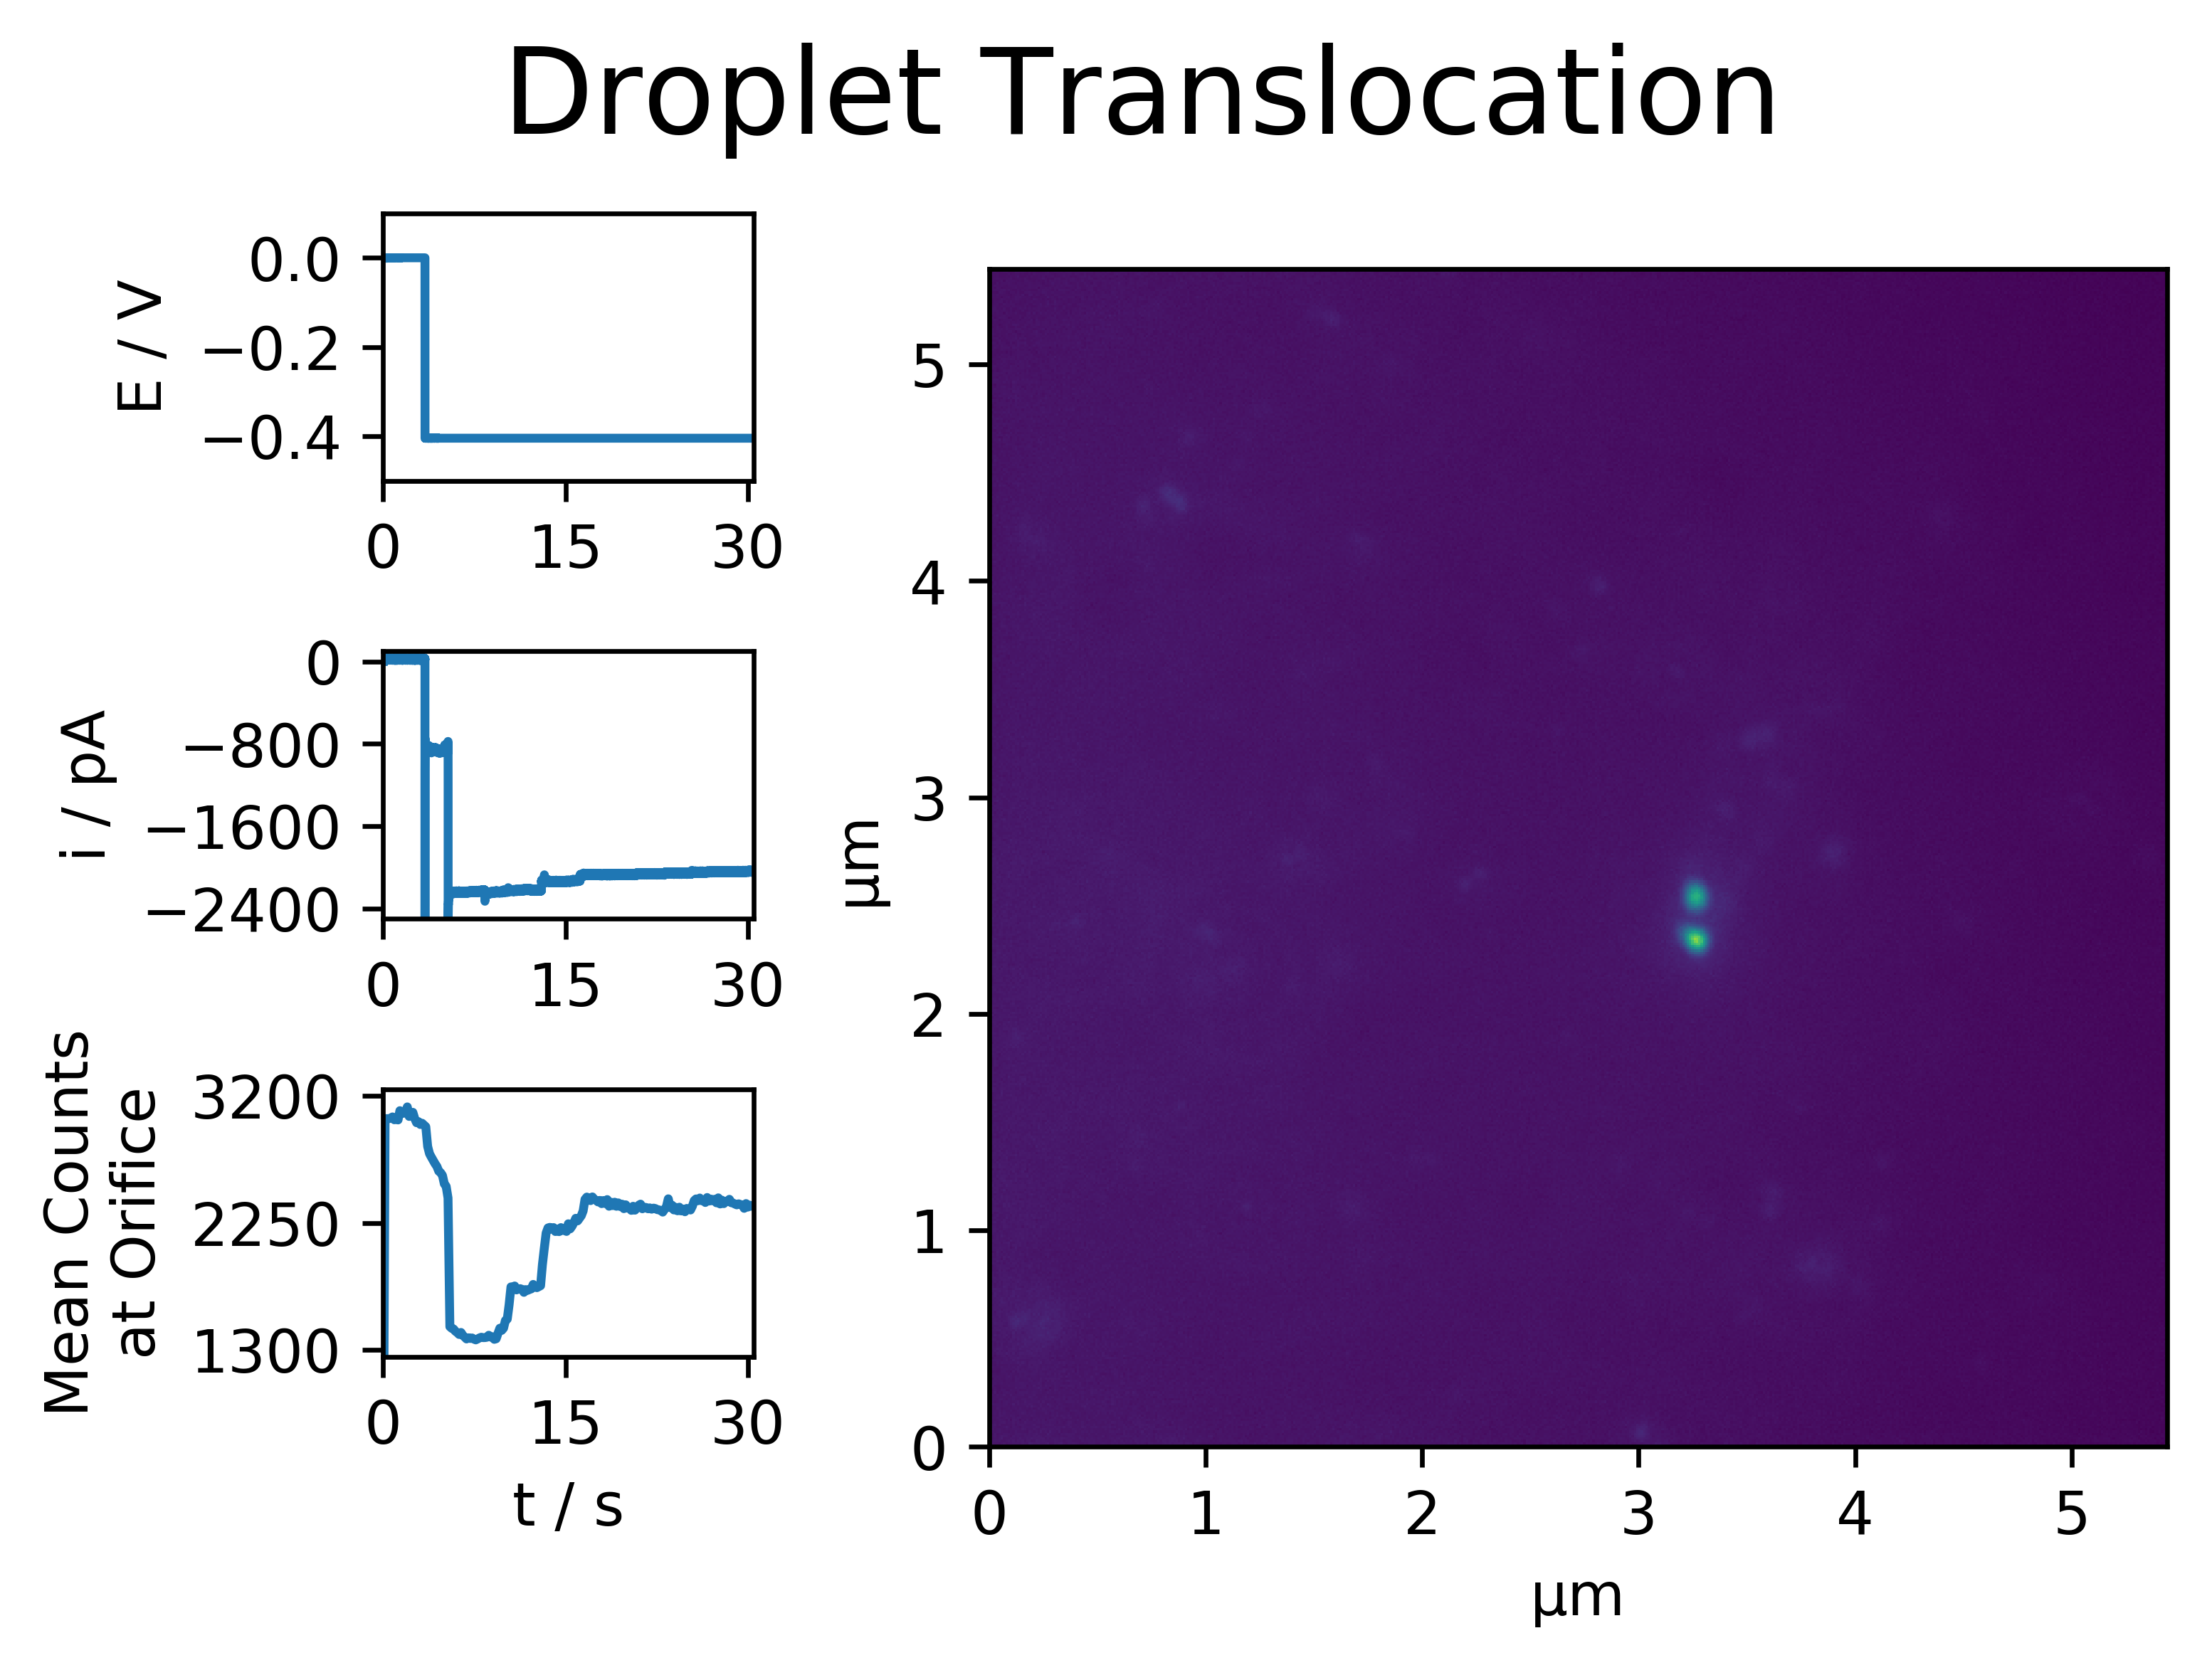

In [2]:
import tifffile as tf
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from matplotlib.gridspec import GridSpec

#load electrical data
data = pd.read_csv('QP8_5mM_TBACl_100kHz_3kHzLP_1_reduced_1.csv')

#load optical data
#mine was as a stack of tif files
#use tifffile to read
tif = tf.imread('run1.tif')

#electrical signal offset,
#which data point in electrical signals
#to designate as start
offset = 0

#designate which tif image
#to start with
#use this and previous offset to
#line up recordings in time
tif_start = 4

#length of each camera image acquisition
#in seconds
#this is the inverse of frame rate which
#would be in Hz
camera_frame_period = 0.15219

#number of camera frames to display
frames = 200

#total time of data to display in ms
#used to define range of electrical data
#for plotting
#factor of 1000 to convert camera_frame_period
#in seconds to milliseconds, 
#important to do this before flooring
total_time_ms = int(np.floor(1000*frames*camera_frame_period))

#in these particular files:
#time is column x,
#current is column y,
#voltage is column z

#could get dt from time_data if desired
#time_data = list(data['x'][offset:offset+total_time_ms])
current_data = list(data['y'][offset:offset+total_time_ms])
voltage_data = list(data['z'][offset:offset+total_time_ms])

#'points per camera frame':
#the number of data points that are
#acquired between each camera acquisition
ppcf = int(np.floor(len(current_data)/frames))

#fluorescence data
#taken as the mean of intensity in a
#sub array of each tif image for
#all tif images in range
#tif_start to tif_start+frames
fl_data = [np.mean(tif[i][286:294,299:309])
          for i in range(tif_start,tif_start+frames)]

#generate plot figure with quality
#dpi=600 is good for me
fig = plt.figure(dpi=600)
fig.suptitle('Droplet Translocation', fontsize=20)

#create grid for subplots
gs = GridSpec(9,10)

#assign subplots to grid
ax1 = plt.subplot(gs[0:2,1:3])
ax2 = plt.subplot(gs[3:5,1:3])
ax3 = plt.subplot(gs[6:8,1:3])

#create instances of Scope for each of
#voltage, current, and fluorescence

#dt for the electrical signals voltage
#and current is 0.001 s
#ppcf is calculated earlier
volt_scope = Scope(ax1, 0.001, ppcf, voltage_data,
                  ylim=(-0.5, 0.1), ylab='E / V',
                  xticks=[0, 15, 30], yticks=[0,-0.2,-0.4])

curr_scope = Scope(ax2, 0.001, ppcf, current_data,
                  ylim=(-2500, 100), ylab='i / pA',
                  xticks=[0, 15, 30], yticks=[0,-800,-1600,-2400])

#dt for fluorescence data is same as camera
#so dt = camera_frame_period
#ppcf = 1 because each camera frame only has
#one corresponding value of fluorescence data
fl_scope = Scope(ax3, camera_frame_period, 1, fl_data,
                 ylim=(1250, 3250), ylab='Mean Counts\nat Orifice',
                 xticks=[0, 15, 30], yticks=[1300,2250,3200],
                 DisplayX = True)

#create subplot over remaining area of
#grid for displaying the camera image
plt.subplot(gs[:,4:])

#5.44 is the field of view in micrometers
#of my optical images
im=plt.imshow(tif[tif_start], extent=(0, 5.44, 0, 5.44))
plt.xlabel(u'\u03bcm')
plt.ylabel(u'\u03bcm')

#function to updates Scopes and display
#the next optical image
#is called with animation function which
#passes an iterator 'cnt' to it
def update_all(cnt):
    scopes = [volt_scope, curr_scope, fl_scope]
    lines = []
    
    #update Scopes
    for scope in scopes:
        lines += scope.update(cnt)
    
    #update image
    im.set_array(tif[tif_start+cnt])
    
    return lines

#how quickly to run the video
#relative to real time
#1 = real time
run_speed = 1

#matplotlib animation
ani = animation.FuncAnimation(fig, update_all, frames=frames-2,
                              interval=run_speed*camera_frame_period*1000,
                              blit=True)

#save with high bitrate for good quality
#bitrate=600 works well for me
ani.save('dtrans.mp4', bitrate=600)

plt.show()